In [44]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

from PIL import Image
import torchvision.transforms as transforms


In [45]:
# Example: read the parquet from huggingface
splits = {
    'train': 'plain_text/train-00000-of-00001.parquet',
    'test' : 'plain_text/test-00000-of-00001.parquet'
}

df_train_full = pd.read_parquet("hf://datasets/uoft-cs/cifar10/" + splits["train"])
print("Full train dataframe shape:", df_train_full.shape)
print(df_train_full.head())


Full train dataframe shape: (50000, 2)
                                                 img  label
0  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      0
1  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      6
2  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      0
3  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      2
4  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      7


In [46]:
NUM_CLASSES = 10

class CifarHFDataset(Dataset):
    def __init__(self, df, transform=None, one_hot=True):
        """
        df must have columns 'img' (dict {'bytes':...}) and 'label' (int).
        transform: a torchvision transform (for images).
        one_hot: if True, convert label to one-hot vector of size NUM_CLASSES.
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.one_hot = one_hot

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # 1) Convert bytes to PIL image
        img_bytes = row["img"]["bytes"]  # dictionary -> 'bytes'
        pil_image = Image.open(io.BytesIO(img_bytes)).convert("RGB")

        # 2) Transform (scale or augment)
        if self.transform:
            img_tensor = self.transform(pil_image)
        else:
            # Convert to tensor if no transform is given
            img_tensor = transforms.ToTensor()(pil_image)  # shape [3,32,32]

        # 3) One-hot encode the label
        label_int = row["label"]
        if self.one_hot:
            # shape => [NUM_CLASSES], e.g. [0,0,0,0,0,0,0,0,0,1] for label 9
            label_vector = torch.zeros(NUM_CLASSES)
            label_vector[label_int] = 1.0
            return img_tensor, label_vector
        else:
            # Just return integer label
            return img_tensor, label_int


In [47]:
# 80% train, 20% test
df_train, df_test = train_test_split(
    df_train_full,
    test_size=0.2,
    random_state=42,
    stratify=df_train_full["label"]
)
print("Train size:", len(df_train), "Test size:", len(df_test))


Train size: 40000 Test size: 10000


In [48]:
# No Augmentation: just scale [0..255] to [0..1]
# We'll further standardize by (mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) if you want
noaug_transform = transforms.Compose([
    transforms.ToTensor(),  # convert [0..255] to float [0..1]
    # transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # optional normalization
])

# With Augmentation (flip, random rotation):
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    # transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])


In [49]:
# No Augmentation: just scale [0..255] to [0..1]
# We'll further standardize by (mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) if you want
noaug_transform = transforms.Compose([
    transforms.ToTensor(),  # convert [0..255] to float [0..1]
    # transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # optional normalization
])

# With Augmentation (flip, random rotation):
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    # transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])


In [50]:
train_dataset_noaug = CifarHFDataset(df_train, transform=noaug_transform, one_hot=True)
test_dataset_noaug  = CifarHFDataset(df_test,  transform=noaug_transform,  one_hot=True)

train_loader_noaug = DataLoader(train_dataset_noaug, batch_size=32, shuffle=True, num_workers=2)
test_loader_noaug  = DataLoader(test_dataset_noaug,  batch_size=32, shuffle=False, num_workers=2)


In [51]:
train_dataset_aug = CifarHFDataset(df_train, transform=aug_transform, one_hot=True)
test_dataset_aug  = CifarHFDataset(df_test,  transform=noaug_transform, one_hot=True)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True, num_workers=2)
test_loader_aug  = DataLoader(test_dataset_aug,  batch_size=32, shuffle=False, num_workers=2)


In [52]:
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        # First 3 conv layers
        self.conv1 = nn.Conv2d(3,   32, kernel_size=3, padding=1)  # => (B,32,32,32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)   # => (B,64,32,32)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)   # => (B,64,32,32)

        self.pool1 = nn.MaxPool2d(2, 2)  # Halve spatial size => (B,64,16,16)

        # Next 2 conv layers
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # => (B,128,16,16)
        self.conv5 = nn.Conv2d(128,128, kernel_size=3, padding=1)  # => (B,128,16,16)

        self.pool2 = nn.MaxPool2d(2, 2)  # => (B,128,8,8)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # First block of convs
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool1(x)  # => (B,64,16,16)

        # Second block of convs
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool2(x)  # => (B,128,8,8)

        # Flatten
        x = x.view(x.size(0), -1)  # => (B,128*8*8)
        x = F.relu(self.fc1(x))    # => (B,256)
        x = self.fc2(x)            # => (B,10)
        return x

In [53]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # => (32 x 32 x 32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # => (64 x 32 x 32)
        self.pool  = nn.MaxPool2d(2,2)                           # => (64 x 16 x 16)

        self.fc1   = nn.Linear(64*16*16, 256)
        self.fc2   = nn.Linear(256, NUM_CLASSES)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # shape => (32,32,32)
        x = F.relu(self.conv2(x))   # shape => (64,32,32)
        x = self.pool(x)            # shape => (64,16,16)
        x = x.view(x.size(0), -1)   # flatten
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)        # shape => [batch, 10], no softmax needed
        return logits


In [54]:
def train_model(train_loader, test_loader, num_epochs=10, lr=0.001, cnn_type="simple"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    if cnn_type == "simple":
        model = SimpleCNN().to(device)
    else:
        model = DeeperCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        # -- TRAIN --
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)           # shape [batch, 10]
            loss = criterion(outputs, labels) # both [batch, 10]
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            # For accuracy, compare argmax of outputs vs. argmax of label
            preds = torch.argmax(outputs, dim=1)
            target_class = torch.argmax(labels, dim=1)
            total += labels.size(0)
            correct += (preds == target_class).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # -- EVAL/TEST --
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)
                preds = torch.argmax(outputs, dim=1)
                target_class = torch.argmax(labels, dim=1)
                total += labels.size(0)
                correct += (preds == target_class).sum().item()

        epoch_test_loss = running_loss / len(test_loader.dataset)
        epoch_test_acc = correct / total
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | "
              f"Test Loss: {epoch_test_loss:.4f}, Acc: {epoch_test_acc:.4f}")

    return model, (train_losses, test_losses, train_accuracies, test_accuracies)


In [55]:
print("=== Training WITHOUT Data Augmentation with a Simple CNN ===")
model_noaug, metrics_noaug = train_model(
    train_loader_noaug,
    test_loader_noaug,
    num_epochs=10,
    lr=0.001
)

print("\n=== Training WITH Data Augmentation with a Simple CNN ===")
model_aug, metrics_aug = train_model(
    train_loader_aug,
    test_loader_aug,
    num_epochs=10,
    lr=0.001
)


print("=== Training WITHOUT Data Augmentation with a Deeper CNN ===")
model_noaug_deeper, metrics_noaug_deeper = train_model(
    train_loader_noaug,
    test_loader_noaug,
    num_epochs=10,
    lr=0.001,
    cnn_type="5 layer"
)

print("\n=== Training WITH Data Augmentation with a Deeper CNN ===")
model_aug_deeper, metrics_aug_deeper = train_model(
    train_loader_aug,
    test_loader_aug,
    num_epochs=10,
    lr=0.001,
    cnn_type="5 layer"
)


=== Training WITHOUT Data Augmentation with a Simple CNN ===
Using device: cuda
Epoch [1/10] | Train Loss: 1.4200, Acc: 0.4851 | Test Loss: 1.1474, Acc: 0.5905
Epoch [2/10] | Train Loss: 1.0086, Acc: 0.6409 | Test Loss: 1.0853, Acc: 0.6209
Epoch [3/10] | Train Loss: 0.8058, Acc: 0.7161 | Test Loss: 0.9636, Acc: 0.6680
Epoch [4/10] | Train Loss: 0.6328, Acc: 0.7762 | Test Loss: 0.9825, Acc: 0.6665
Epoch [5/10] | Train Loss: 0.4778, Acc: 0.8337 | Test Loss: 1.0834, Acc: 0.6576
Epoch [6/10] | Train Loss: 0.3336, Acc: 0.8840 | Test Loss: 1.2979, Acc: 0.6549
Epoch [7/10] | Train Loss: 0.2188, Acc: 0.9247 | Test Loss: 1.5570, Acc: 0.6513
Epoch [8/10] | Train Loss: 0.1515, Acc: 0.9481 | Test Loss: 1.7376, Acc: 0.6480
Epoch [9/10] | Train Loss: 0.1218, Acc: 0.9592 | Test Loss: 1.9717, Acc: 0.6550
Epoch [10/10] | Train Loss: 0.0884, Acc: 0.9707 | Test Loss: 2.1075, Acc: 0.6516

=== Training WITH Data Augmentation with a Simple CNN ===
Using device: cuda
Epoch [1/10] | Train Loss: 1.4509, Acc: 0

In [56]:
def plot_metrics(metrics, title_prefix="Model"):
    train_losses, test_losses, train_accs, test_accs = metrics

    epochs = range(1, len(train_losses)+1)

    fig, ax = plt.subplots(1,2, figsize=(12,5))

    ax[0].plot(epochs, train_losses, label="Train Loss")
    ax[0].plot(epochs, test_losses, label="Test Loss")
    ax[0].set_title(f"{title_prefix} Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    ax[1].plot(epochs, train_accs, label="Train Acc")
    ax[1].plot(epochs, test_accs, label="Test Acc")
    ax[1].set_title(f"{title_prefix} Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()

    plt.show()


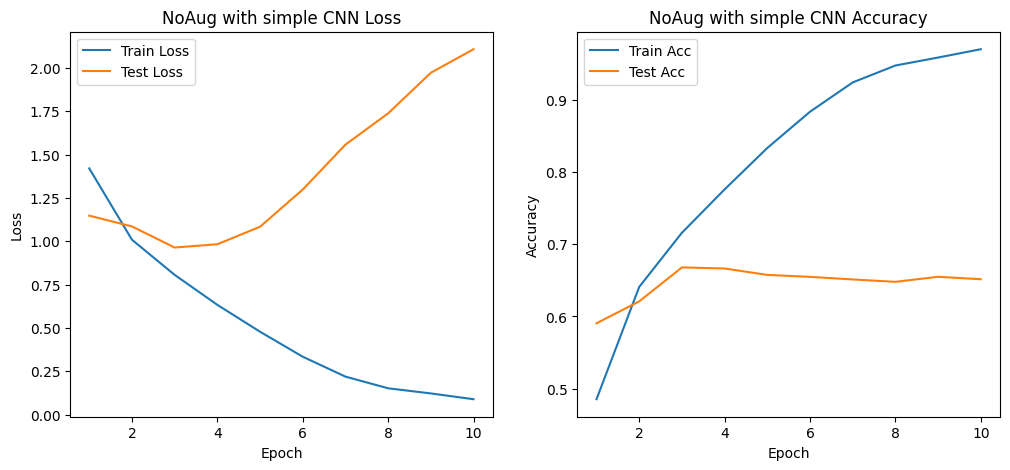

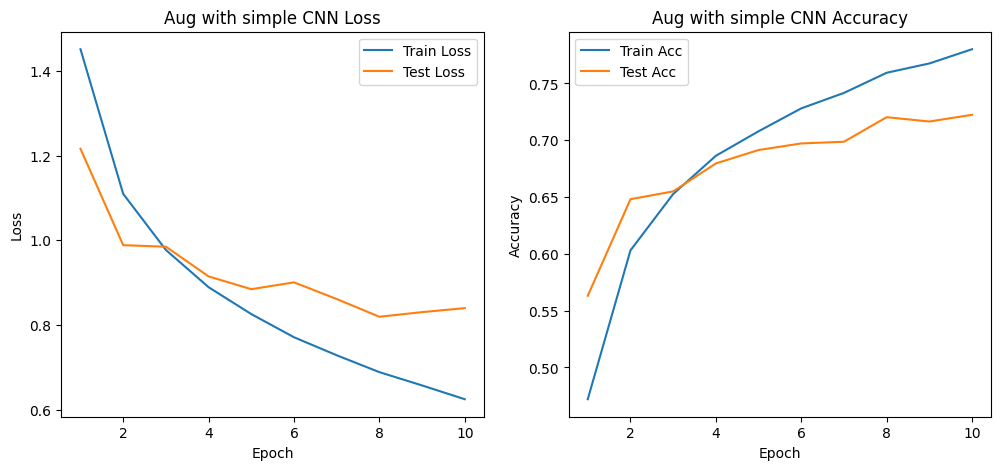

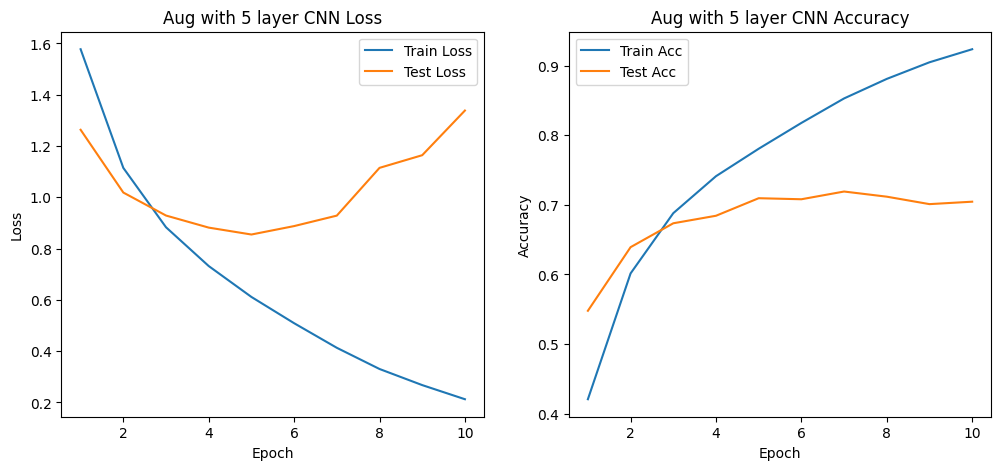

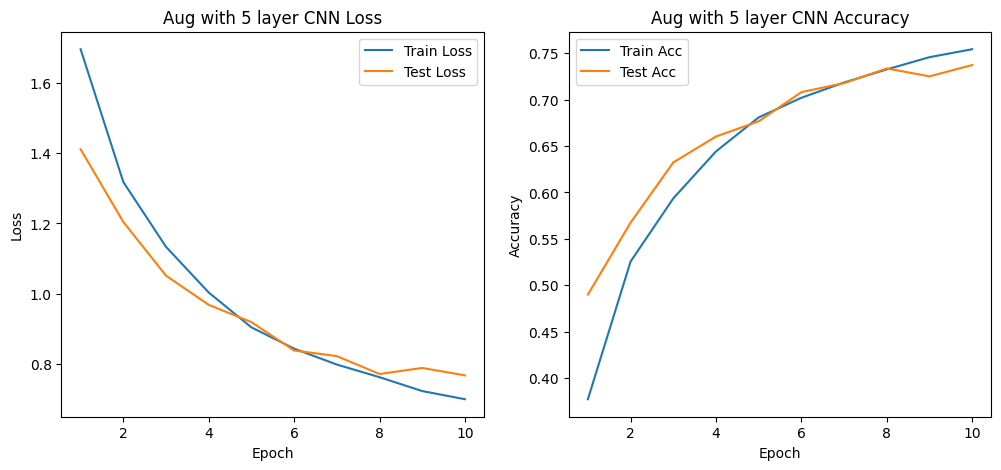

In [57]:
# Plot for no augmentation
plot_metrics(metrics_noaug, title_prefix="NoAug with simple CNN")

# Plot for augmentation
plot_metrics(metrics_aug,  title_prefix="Aug with simple CNN")

plot_metrics(metrics_noaug_deeper,  title_prefix="Aug with 5 layer CNN")
plot_metrics(metrics_aug_deeper,  title_prefix="Aug with 5 layer CNN")



In [58]:
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            # labels are one-hot => must find class indices
            label_indices = torch.argmax(labels, dim=1).cpu().numpy()
            all_labels.extend(label_indices)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)

    # Precision/recall/f1 with integer class labels
    precision = precision_score(all_labels, all_preds, average='macro')
    recall    = recall_score(all_labels, all_preds, average='macro')
    f1        = f1_score(all_labels, all_preds, average='macro')
    accuracy  = np.mean(np.array(all_labels) == np.array(all_preds))

    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, precision, recall, f1, cm


No Aug Results:
Accuracy:  0.6516
Precision: 0.6570
Recall:    0.6516
F1-score:  0.6527


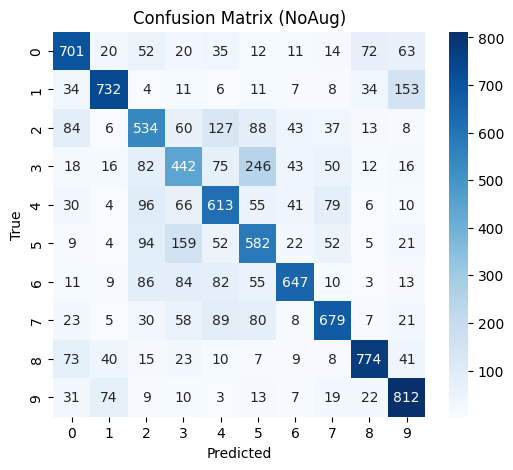

In [59]:
acc_noaug, pre_noaug, rec_noaug, f1_noaug, cm_noaug = evaluate_model(model_noaug, test_loader_noaug)
print("No Aug Results:")
print(f"Accuracy:  {acc_noaug:.4f}")
print(f"Precision: {pre_noaug:.4f}")
print(f"Recall:    {rec_noaug:.4f}")
print(f"F1-score:  {f1_noaug:.4f}")

plt.figure(figsize=(6,5))
sns.heatmap(cm_noaug, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (NoAug)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Aug Results:
Accuracy:  0.7224
Precision: 0.7206
Recall:    0.7224
F1-score:  0.7199


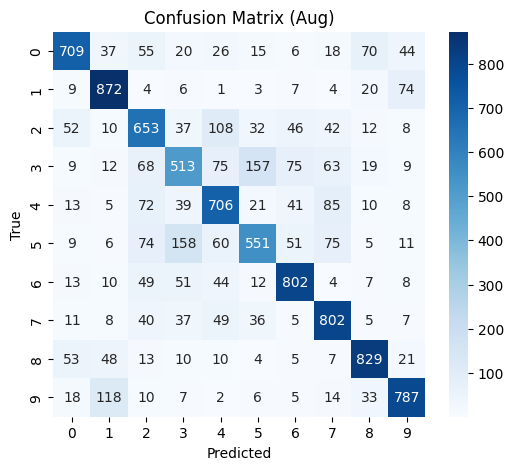

In [60]:
acc_aug, pre_aug, rec_aug, f1_aug, cm_aug = evaluate_model(model_aug, test_loader_aug)
print("Aug Results:")
print(f"Accuracy:  {acc_aug:.4f}")
print(f"Precision: {pre_aug:.4f}")
print(f"Recall:    {rec_aug:.4f}")
print(f"F1-score:  {f1_aug:.4f}")

plt.figure(figsize=(6,5))
sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Aug)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Feature maps from conv1 (NoAug model)


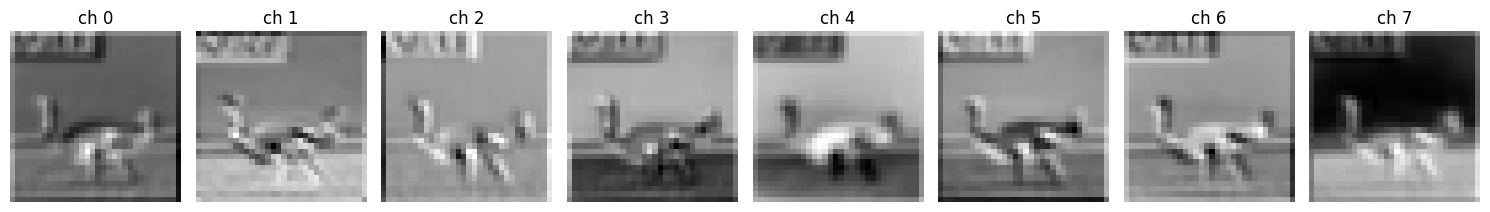

In [61]:
def visualize_feature_maps(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    # Grab 1 batch
    images, _ = next(iter(loader))
    images = images[:1].to(device)  # just take 1 sample

    with torch.no_grad():
        # pass through first conv
        feat = model.conv1(images)  # shape => (1,32,32,32)

    # remove batch dimension
    feat = feat[0]  # shape => (32,32,32)
    feat = feat.cpu().numpy()

    # let's visualize first 8 channels
    n_channels = 8
    fig, axes = plt.subplots(1,n_channels, figsize=(15,3))
    for i in range(n_channels):
        axes[i].imshow(feat[i], cmap='gray')
        axes[i].set_title(f"ch {i}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

print("Feature maps from conv1 (NoAug model)")
visualize_feature_maps(model_noaug, test_loader_noaug)


=== Training with LR=0.001 ===
Using device: cuda
Epoch [1/10] | Train Loss: 1.3845, Acc: 0.5020 | Test Loss: 1.0833, Acc: 0.6125
Epoch [2/10] | Train Loss: 0.9384, Acc: 0.6684 | Test Loss: 0.9714, Acc: 0.6602
Epoch [3/10] | Train Loss: 0.7176, Acc: 0.7474 | Test Loss: 0.9626, Acc: 0.6735
Epoch [4/10] | Train Loss: 0.5127, Acc: 0.8205 | Test Loss: 0.9947, Acc: 0.6868
Epoch [5/10] | Train Loss: 0.3199, Acc: 0.8904 | Test Loss: 1.2045, Acc: 0.6727
Epoch [6/10] | Train Loss: 0.1884, Acc: 0.9359 | Test Loss: 1.4045, Acc: 0.6691
Epoch [7/10] | Train Loss: 0.1089, Acc: 0.9642 | Test Loss: 1.6923, Acc: 0.6701
Epoch [8/10] | Train Loss: 0.0903, Acc: 0.9703 | Test Loss: 1.8270, Acc: 0.6638
Epoch [9/10] | Train Loss: 0.0693, Acc: 0.9762 | Test Loss: 1.9935, Acc: 0.6810
Epoch [10/10] | Train Loss: 0.0642, Acc: 0.9782 | Test Loss: 2.2332, Acc: 0.6651


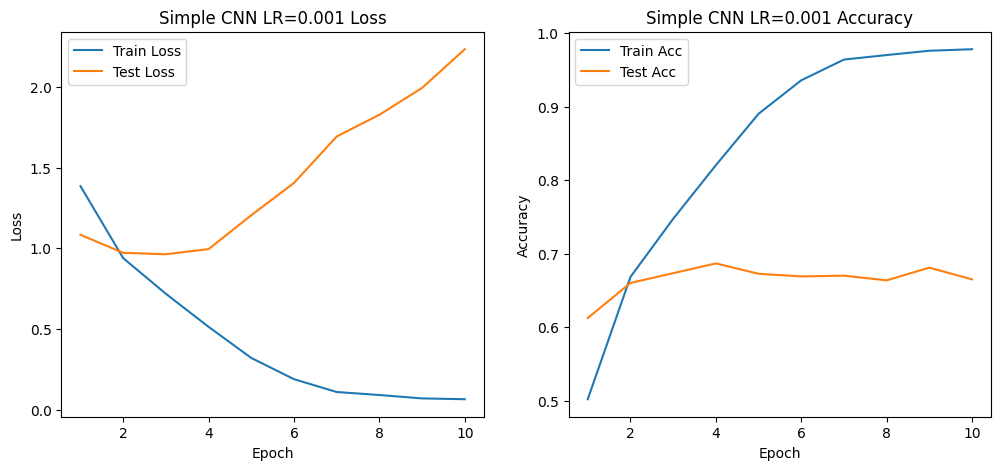

=== Training with LR=0.01 ===
Using device: cuda
Epoch [1/10] | Train Loss: 1.3713, Acc: 0.5081 | Test Loss: 1.1019, Acc: 0.6099
Epoch [2/10] | Train Loss: 0.9643, Acc: 0.6579 | Test Loss: 0.9970, Acc: 0.6477
Epoch [3/10] | Train Loss: 0.7583, Acc: 0.7309 | Test Loss: 0.9678, Acc: 0.6702
Epoch [4/10] | Train Loss: 0.5714, Acc: 0.7995 | Test Loss: 0.9711, Acc: 0.6764
Epoch [5/10] | Train Loss: 0.3920, Acc: 0.8619 | Test Loss: 1.0800, Acc: 0.6795
Epoch [6/10] | Train Loss: 0.2421, Acc: 0.9164 | Test Loss: 1.3191, Acc: 0.6695
Epoch [7/10] | Train Loss: 0.1526, Acc: 0.9479 | Test Loss: 1.5664, Acc: 0.6649
Epoch [8/10] | Train Loss: 0.1087, Acc: 0.9631 | Test Loss: 1.8160, Acc: 0.6605
Epoch [9/10] | Train Loss: 0.0846, Acc: 0.9718 | Test Loss: 2.0367, Acc: 0.6641
Epoch [10/10] | Train Loss: 0.0830, Acc: 0.9715 | Test Loss: 2.0981, Acc: 0.6688


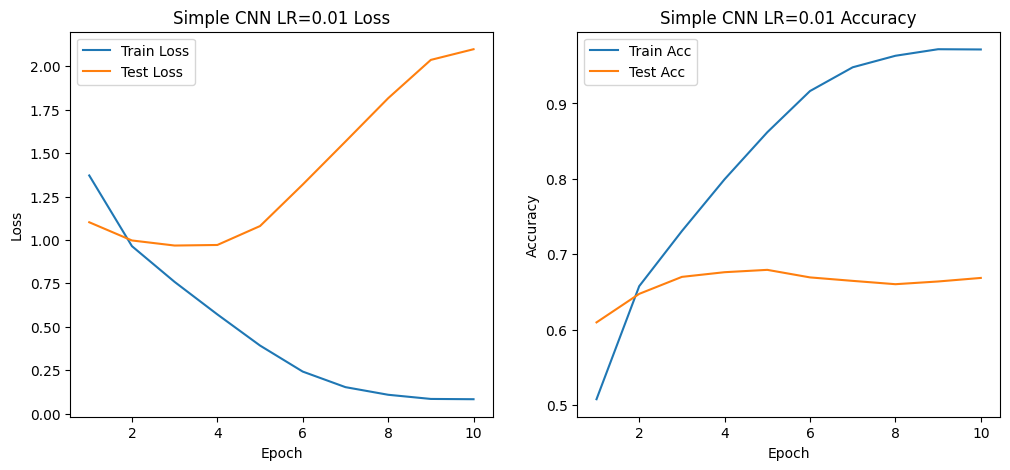

=== Training with LR=0.1 ===
Using device: cuda
Epoch [1/10] | Train Loss: 1.3747, Acc: 0.5072 | Test Loss: 1.1016, Acc: 0.6109
Epoch [2/10] | Train Loss: 0.9471, Acc: 0.6661 | Test Loss: 0.9616, Acc: 0.6666
Epoch [3/10] | Train Loss: 0.7374, Acc: 0.7393 | Test Loss: 0.9497, Acc: 0.6752
Epoch [4/10] | Train Loss: 0.5393, Acc: 0.8105 | Test Loss: 0.9920, Acc: 0.6786
Epoch [5/10] | Train Loss: 0.3508, Acc: 0.8772 | Test Loss: 1.1821, Acc: 0.6683
Epoch [6/10] | Train Loss: 0.2043, Acc: 0.9311 | Test Loss: 1.4528, Acc: 0.6703
Epoch [7/10] | Train Loss: 0.1279, Acc: 0.9567 | Test Loss: 1.6867, Acc: 0.6540
Epoch [8/10] | Train Loss: 0.0894, Acc: 0.9700 | Test Loss: 1.9858, Acc: 0.6609
Epoch [9/10] | Train Loss: 0.0799, Acc: 0.9734 | Test Loss: 2.1477, Acc: 0.6472
Epoch [10/10] | Train Loss: 0.0630, Acc: 0.9788 | Test Loss: 2.2908, Acc: 0.6612


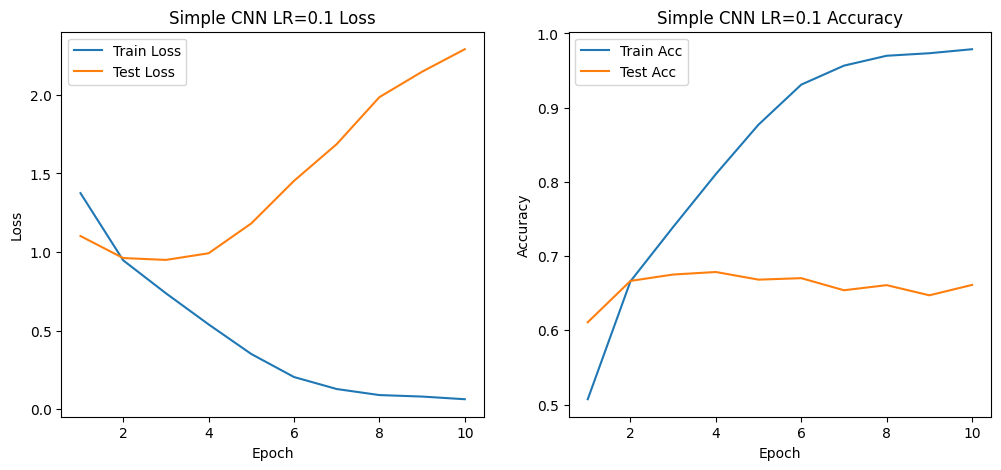

LR | Acc | Prec | Recall | F1
0.001 | 0.6651 | 0.6722 | 0.6651 | 0.6666
0.01 | 0.6688 | 0.6686 | 0.6688 | 0.6643
0.1 | 0.6612 | 0.6678 | 0.6612 | 0.6611


In [64]:
lr_list = [0.001, 0.01, 0.1]
results = []
for lr in lr_list:
    print(f"=== Training with LR={lr} ===")
    model_lr, metrics_lr = train_model(train_loader_noaug, test_loader_noaug,
                                       num_epochs=10, lr=lr)
    acc_lr, pre_lr, rec_lr, f1_lr, cm_lr = evaluate_model(model_lr, test_loader_noaug)
    results.append((lr, acc_lr, pre_lr, rec_lr, f1_lr))
    plot_metrics(metrics_lr, title_prefix=f"Simple CNN LR={lr}")

# Print results in a table
print("LR | Acc | Prec | Recall | F1")
for r in results:
    print(f"{r[0]} | {r[1]:.4f} | {r[2]:.4f} | {r[3]:.4f} | {r[4]:.4f}")


=== Training with LR=0.001 ===
Using device: cuda
Epoch [1/10] | Train Loss: 1.5414, Acc: 0.4375 | Test Loss: 1.2108, Acc: 0.5646
Epoch [2/10] | Train Loss: 1.0112, Acc: 0.6417 | Test Loss: 0.9148, Acc: 0.6754
Epoch [3/10] | Train Loss: 0.7923, Acc: 0.7181 | Test Loss: 0.8419, Acc: 0.7055
Epoch [4/10] | Train Loss: 0.6394, Acc: 0.7739 | Test Loss: 0.8014, Acc: 0.7232
Epoch [5/10] | Train Loss: 0.5032, Acc: 0.8251 | Test Loss: 0.9279, Acc: 0.7020
Epoch [6/10] | Train Loss: 0.3874, Acc: 0.8639 | Test Loss: 0.9377, Acc: 0.7265
Epoch [7/10] | Train Loss: 0.2831, Acc: 0.8995 | Test Loss: 1.0665, Acc: 0.7171
Epoch [8/10] | Train Loss: 0.2173, Acc: 0.9225 | Test Loss: 1.2096, Acc: 0.7186
Epoch [9/10] | Train Loss: 0.1730, Acc: 0.9401 | Test Loss: 1.2814, Acc: 0.7199
Epoch [10/10] | Train Loss: 0.1402, Acc: 0.9508 | Test Loss: 1.3614, Acc: 0.7185


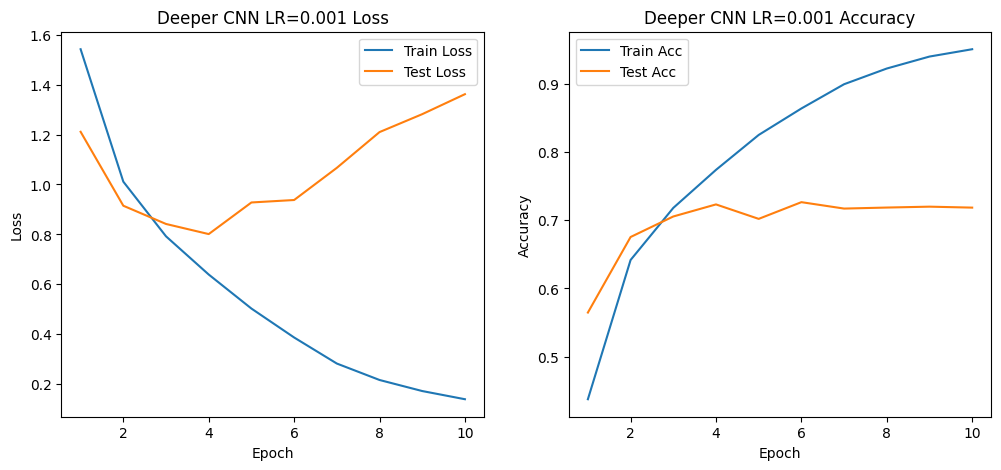

=== Training with LR=0.01 ===
Using device: cuda
Epoch [1/10] | Train Loss: 1.5700, Acc: 0.4224 | Test Loss: 1.2648, Acc: 0.5451
Epoch [2/10] | Train Loss: 1.1161, Acc: 0.6006 | Test Loss: 1.0303, Acc: 0.6393
Epoch [3/10] | Train Loss: 0.8914, Acc: 0.6845 | Test Loss: 0.9118, Acc: 0.6808
Epoch [4/10] | Train Loss: 0.7513, Acc: 0.7370 | Test Loss: 0.8775, Acc: 0.6934
Epoch [5/10] | Train Loss: 0.6395, Acc: 0.7729 | Test Loss: 0.8534, Acc: 0.7087
Epoch [6/10] | Train Loss: 0.5340, Acc: 0.8125 | Test Loss: 0.9206, Acc: 0.7046
Epoch [7/10] | Train Loss: 0.4399, Acc: 0.8424 | Test Loss: 0.9685, Acc: 0.7089
Epoch [8/10] | Train Loss: 0.3620, Acc: 0.8716 | Test Loss: 1.0418, Acc: 0.7026
Epoch [9/10] | Train Loss: 0.2921, Acc: 0.8949 | Test Loss: 1.2040, Acc: 0.7005
Epoch [10/10] | Train Loss: 0.2379, Acc: 0.9159 | Test Loss: 1.3450, Acc: 0.6894


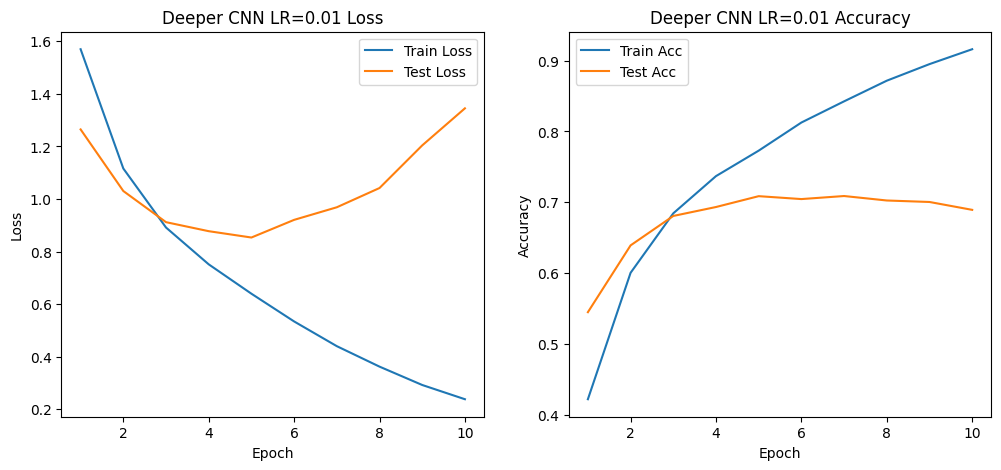

=== Training with LR=0.1 ===
Using device: cuda
Epoch [1/10] | Train Loss: 1.5599, Acc: 0.4350 | Test Loss: 1.2966, Acc: 0.5274
Epoch [2/10] | Train Loss: 1.1030, Acc: 0.6055 | Test Loss: 0.9799, Acc: 0.6513
Epoch [3/10] | Train Loss: 0.8636, Acc: 0.6924 | Test Loss: 0.8757, Acc: 0.6928
Epoch [4/10] | Train Loss: 0.7090, Acc: 0.7500 | Test Loss: 0.8332, Acc: 0.7096
Epoch [5/10] | Train Loss: 0.5892, Acc: 0.7927 | Test Loss: 0.8636, Acc: 0.7091
Epoch [6/10] | Train Loss: 0.4866, Acc: 0.8262 | Test Loss: 0.8709, Acc: 0.7245
Epoch [7/10] | Train Loss: 0.3924, Acc: 0.8598 | Test Loss: 0.9417, Acc: 0.7211
Epoch [8/10] | Train Loss: 0.3091, Acc: 0.8894 | Test Loss: 1.0895, Acc: 0.7117
Epoch [9/10] | Train Loss: 0.2490, Acc: 0.9102 | Test Loss: 1.1432, Acc: 0.7055
Epoch [10/10] | Train Loss: 0.1973, Acc: 0.9296 | Test Loss: 1.3979, Acc: 0.7038


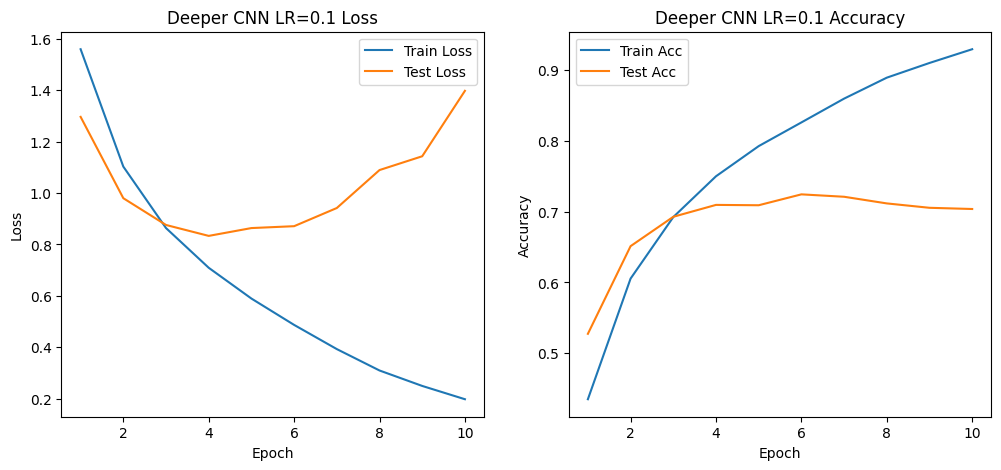

LR | Acc | Prec | Recall | F1
0.001 | 0.7185 | 0.7202 | 0.7185 | 0.7186
0.01 | 0.6894 | 0.6956 | 0.6894 | 0.6892
0.1 | 0.7038 | 0.7142 | 0.7038 | 0.7055


In [65]:
lr_list = [0.001, 0.01, 0.1]
results = []
for lr in lr_list:
    print(f"=== Training with LR={lr} ===")
    model_lr, metrics_lr = train_model(train_loader_noaug, test_loader_noaug,
                                       num_epochs=10, lr=lr, cnn_type="deeper")
    acc_lr, pre_lr, rec_lr, f1_lr, cm_lr = evaluate_model(model_lr, test_loader_noaug)
    results.append((lr, acc_lr, pre_lr, rec_lr, f1_lr))
    plot_metrics(metrics_lr, title_prefix=f"Deeper CNN LR={lr}")


# Print results in a table
print("LR | Acc | Prec | Recall | F1")
for r in results:
    print(f"{r[0]} | {r[1]:.4f} | {r[2]:.4f} | {r[3]:.4f} | {r[4]:.4f}")
